# preprocessing script for dashbaord 

In [1]:
import os
import time
import random
import warnings
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import src.util as util
import src.rv as rv
import src.lstm as lstm

# Suppress warnings
warnings.filterwarnings("ignore")

# Reload modules to pick up any changes
importlib.reload(util)
importlib.reload(rv)
importlib.reload(lstm)

# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [9]:
#!pip install statsmodels
!pip install pyarrow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 11.4 MB/s eta 0:00:0000:0100:01


In [2]:
# 1. Load order book features and targets
feature_df = pd.read_parquet("data/order_book_feature.parquet", engine='pyarrow')
target_df = pd.read_parquet("data/order_book_target.parquet", engine='pyarrow')

# 2. Combine and sort
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# 3. Compute snapshot features
snapshot_features_df = util.create_snapshot_features(combined_df)

# 4. ✅ Filter only the three stock_ids
stock_ids = [50200, 104919]
snapshot_features_df = snapshot_features_df[snapshot_features_df["stock_id"].isin(stock_ids)]

# 5. Final sort for consistency
snapshot_features_df = snapshot_features_df.sort_values(
    by=['stock_id', 'time_id', 'seconds_in_bucket']
).reset_index(drop=True)


In [ ]:
np.random.seed(3888)  # for reproducibility
importlib.reload(util)
from src.util import generate_tick_sequences

# Ensure output directory exists
os.makedirs("dashboard/data", exist_ok=True)

# List of stock_ids you want to process
stock_ids = [50200, 104919, 22771]

# List of high-volatility time_ids
chosen_ids = [14, 46, 54, 246]

# Feature columns used in your model
feature_cols = [
    "wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
    "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"
]

# Loop over all stock_id and time_id combinations
for stock_id in stock_ids:
    df_stock = snapshot_features_df[snapshot_features_df["stock_id"] == stock_id]
    for time_id in chosen_ids:
        df_tid = df_stock[df_stock["time_id"] == time_id].copy()
        output_path = f"dashboard/data/{stock_id}_tid{time_id}.pkl"  # define first!

        if os.path.exists(output_path):
            print(f"⏭️  Skipping existing file: {output_path}")
            continue

        if df_tid.empty:
            print(f"⚠️ Skipping stock_id {stock_id}, time_id {time_id} (no data)")
            continue
        rolling_features_df = util.generate_rolling_features(df_tid)
        seq_df = generate_tick_sequences(df_tid, feature_cols)

        seq_df.to_pickle(output_path)
        print(f"✅ Saved {output_path}")



✅ Saved dashboard/data/50200_tid14.pkl
✅ Saved dashboard/data/50200_tid46.pkl
✅ Saved dashboard/data/50200_tid54.pkl
✅ Saved dashboard/data/50200_tid246.pkl
✅ Saved dashboard/data/104919_tid14.pkl
✅ Saved dashboard/data/104919_tid46.pkl
✅ Saved dashboard/data/104919_tid54.pkl
✅ Saved dashboard/data/104919_tid246.pkl
✅ Saved dashboard/data/22771_tid14.pkl
✅ Saved dashboard/data/22771_tid46.pkl
✅ Saved dashboard/data/22771_tid54.pkl
✅ Saved dashboard/data/22771_tid246.pkl


In [ ]:
#  checking if 1 time id is 1 hour 
df = snapshot_features_df[snapshot_features_df["time_id"] == 246]
print(df["seconds_in_bucket"].min(), df["seconds_in_bucket"].max())


1.0 3599.0


In [8]:
import os
import importlib
import numpy as np
import pandas as pd
import src.util as util

np.random.seed(3888)
importlib.reload(util)

# Create output folder
os.makedirs("dashboard/data", exist_ok=True)

# Stock IDs to process
stock_ids = [50200, 104919, 22771]

for stock_id in stock_ids:
    print(f"📦 Processing stock {stock_id}")
    df_stock = snapshot_features_df[snapshot_features_df["stock_id"] == stock_id].copy()
    if df_stock.empty:
        print(f"⚠️ Skipping stock_id {stock_id} (no data)")
        continue

    df_stock = df_stock.sort_values(by=["time_id", "seconds_in_bucket"]).reset_index(drop=True)

    # 1. Compute bucket
    df_stock["bucket_id_330s"] = df_stock["seconds_in_bucket"] // 330

    # 2. Compute realized volatility
    df_stock["log_return_squared"] = df_stock["log_return"] ** 2
    rv_df = df_stock.groupby("time_id")["log_return_squared"].sum().reset_index()
    rv_df["realized_volatility"] = np.sqrt(rv_df["log_return_squared"])

    # 3. ✅ Aggregate snapshot features at bucket level (now includes mid_price)
    agg_df = df_stock.groupby(["time_id", "bucket_id_330s"]).agg({
        "wap": "mean",
        "mid_price": "mean",  # ✅ add this line!
        "spread_pct": "mean",
        "imbalance": "mean",
        "depth_ratio": "mean",
        "log_return": "mean",
        "bid_ask_spread": "mean"
    }).reset_index()

    # 4. Compute lead target for spread
    agg_df["bid_ask_spread_lead1"] = agg_df.groupby("time_id")["bid_ask_spread"].shift(-1)
    agg_df = agg_df.dropna().reset_index(drop=True)

    # 5. Merge in realized volatility
    agg_df = pd.merge(agg_df, rv_df[["time_id", "realized_volatility"]], on="time_id", how="left")

    # 6. Save to disk
    output_path = f"dashboard/data/spread_features_{stock_id}_alltimeid.pkl"
    agg_df.to_pickle(output_path)
    print(f"✅ Saved {output_path} with shape {agg_df.shape}")


📦 Processing stock 50200
✅ Saved dashboard/data/spread_features_50200_alltimeid.pkl with shape (11550, 11)
📦 Processing stock 104919
✅ Saved dashboard/data/spread_features_104919_alltimeid.pkl with shape (11550, 11)
📦 Processing stock 22771
⚠️ Skipping stock_id 22771 (no data)


In [ ]:
"""
====================================================================
Purpose: Identify time_ids with high volatility and sudden spikes
====================================================================

1. Identify:
   - The top 5 time_ids with the highest overall volatility.
   - The top 10 time_ids with the biggest increases in volatility 
     relative to the previous time bucket (volatility "spikes").

To get time_ids to be included in the dashboard

====================================================================
"""
# Filter for a specific stock
df_50200 = snapshot_features_df[snapshot_features_df['stock_id'] == 50200]

# Compute std of log return per time_id
vol_per_time = df_50200.groupby("time_id")["log_return"].std().reset_index()
vol_per_time.columns = ["time_id", "log_return_std"]

# Sort by time_id (ascending) to compute proper difference
vol_per_time = vol_per_time.sort_values("time_id").reset_index(drop=True)

# Compute spike in volatility as difference from previous bucket
vol_per_time["vol_spike"] = vol_per_time["log_return_std"].diff()

# Top time_ids with highest overall volatility
top_vol = vol_per_time.sort_values("log_return_std", ascending=False).head(5)
print("Top volatility time_ids:")
print(top_vol)

# Top time_ids with biggest volatility spikes
top_spike = vol_per_time.sort_values("vol_spike", ascending=False).head(10)
print("\nTop spike time_ids:")
print(top_spike)




In [19]:
"""
===============================================================
Purpose: Identify best-matching LSTM predictions by MAE score
===============================================================

This script loads all prediction .pkl files in the dashboard,
and evaluates how well the predicted volatility (y_pred) matches
the actual (y_true) over a short future horizon (e.g., next 30s).

Steps:
1. Filter each prediction DataFrame to keep data from `cutoff`
   (e.g. 1500s) to `cutoff + horizon` seconds.
2. Skip empty or invalid predictions.
3. Compute MAE (mean absolute error) between y_pred and y_true.
4. Return top files with lowest MAE – i.e., where prediction 
   most closely matches actual.

Used for selecting good examples to show in demo.

===============================================================
"""
import pandas as pd
import glob
import os

results = []
# prediciton start at 1000/1500/... seconds in bucket 
cutoff = 1650
horizon = 30  # or 60

for file in glob.glob("dashboard/predictions/*.pkl"):
    df = pd.read_pickle(file)
    if 'y_pred' not in df.columns or df['y_pred'].isnull().all():
        continue
    df_horizon = df[(df['start_time'] >= cutoff) & (df['start_time'] <= cutoff + horizon)].copy()
    if df_horizon.empty:
        continue
    mae = abs(df_horizon['y_true'] - df_horizon['y_pred']).mean()
    results.append((file, mae))

# Sort and view top matches
sorted_results = sorted(results, key=lambda x: x[1])
# see only the top 3 (add more if we want more time id on dashbaord)
for fname, error in sorted_results[:3]:
    print(f"{fname} | MAE over next {horizon}s = {error:.6f}")


dashboard/predictions/pred_50200_54.pkl | MAE over next 30s = 0.000017
dashboard/predictions/pred_50200_246.pkl | MAE over next 30s = 0.000040
dashboard/predictions/pred_50200_14.pkl | MAE over next 30s = 0.000062


In [43]:
import pandas as pd
import glob

results = []
cutoff = 1000
horizon = 60  # or 30

for file in glob.glob("dashboard/predictions/*.pkl"):
    df = pd.read_pickle(file)
    if 'y_pred' not in df.columns or df['y_pred'].isnull().all():
        continue

    df_horizon = df[(df['start_time'] >= cutoff) & (df['start_time'] <= cutoff + horizon)]
    if df_horizon.empty or df_horizon['y_pred'].isnull().all():
        continue

    mae = abs(df_horizon['y_true'] - df_horizon['y_pred']).mean()
    corr = df_horizon['y_true'].corr(df_horizon['y_pred'])  # visual match
    var_pred = df_horizon['y_pred'].std()

    # Bonus: store everything
    results.append((file, mae, corr, var_pred))

# Sort by best combination of low MAE and high correlation
sorted_results = sorted(results, key=lambda x: (x[1], -x[2], -x[3]))

# Show top 5 visually promising candidates
for fname, mae, corr, var in sorted_results[:5]:
    print(f"{fname} | MAE: {mae:.6f} | Corr: {corr:.2f} | Var(pred): {var:.6f}")


dashboard/predictions/pred_50200_54.pkl | MAE: 0.000012 | Corr: -0.36 | Var(pred): 0.000006
dashboard/predictions/pred_50200_46.pkl | MAE: 0.000020 | Corr: 0.47 | Var(pred): 0.000010
dashboard/predictions/pred_50200_246.pkl | MAE: 0.000025 | Corr: -0.27 | Var(pred): 0.000007
dashboard/predictions/pred_50200_14.pkl | MAE: 0.000028 | Corr: 0.10 | Var(pred): 0.000009


In [42]:
df = pd.read_pickle("dashboard/predictions/pred_50200_246.pkl")
print(df["start_time"].min(), df["start_time"].max())


1.0 3256.0


### Time ID selection 

removed time id 108, 132, 222, 282, 588, 804,846, 1116, 1194 

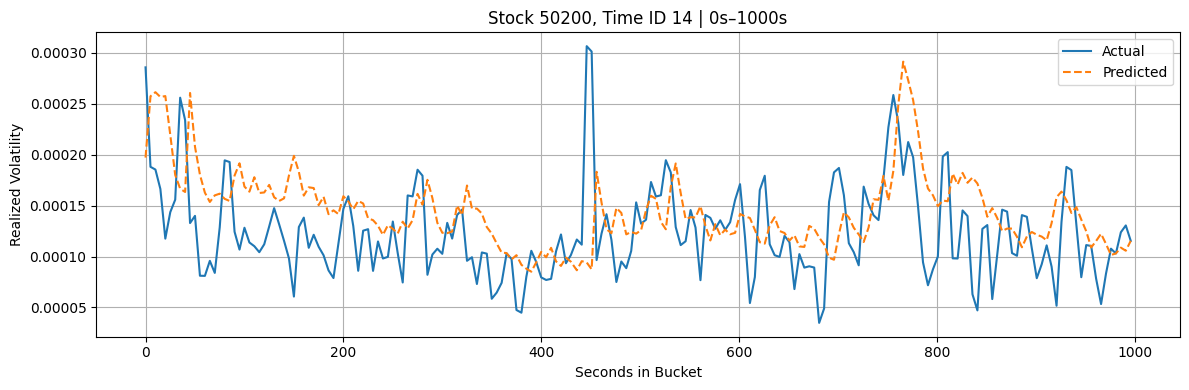

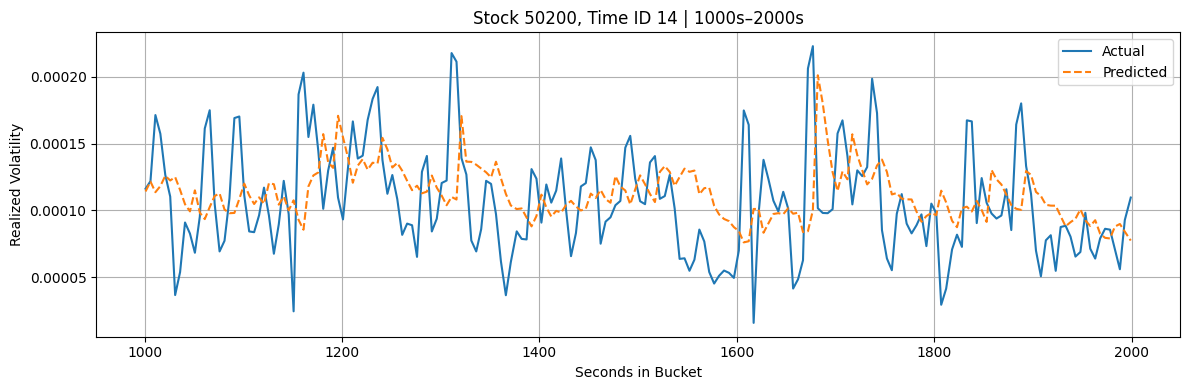

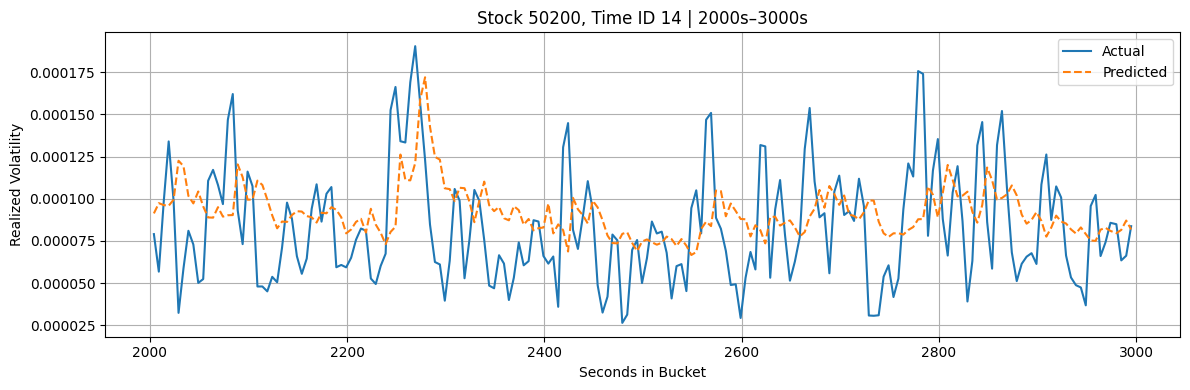

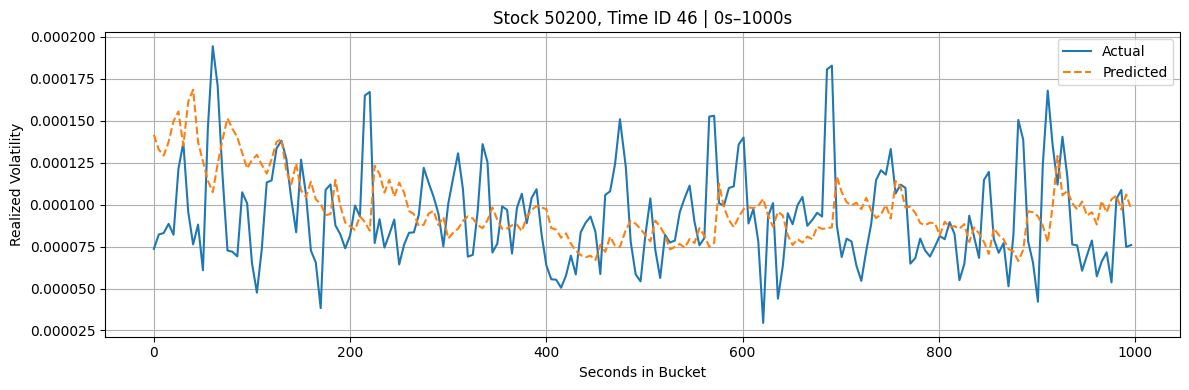

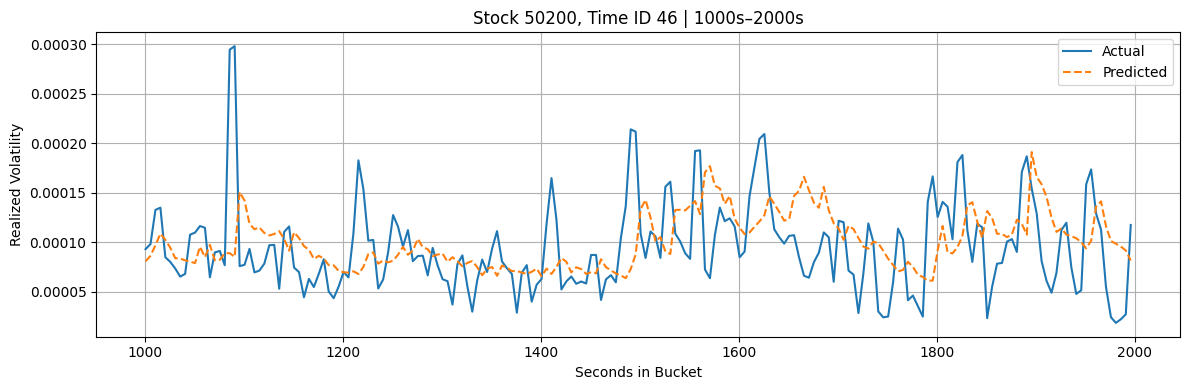

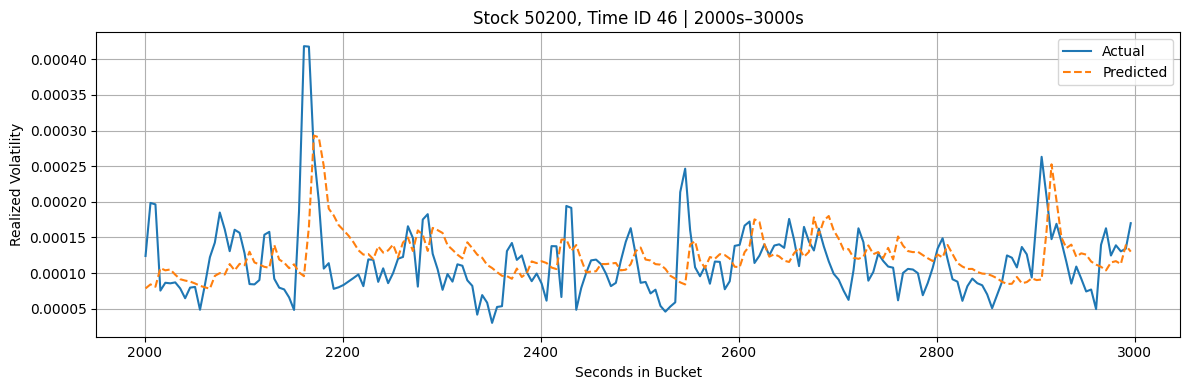

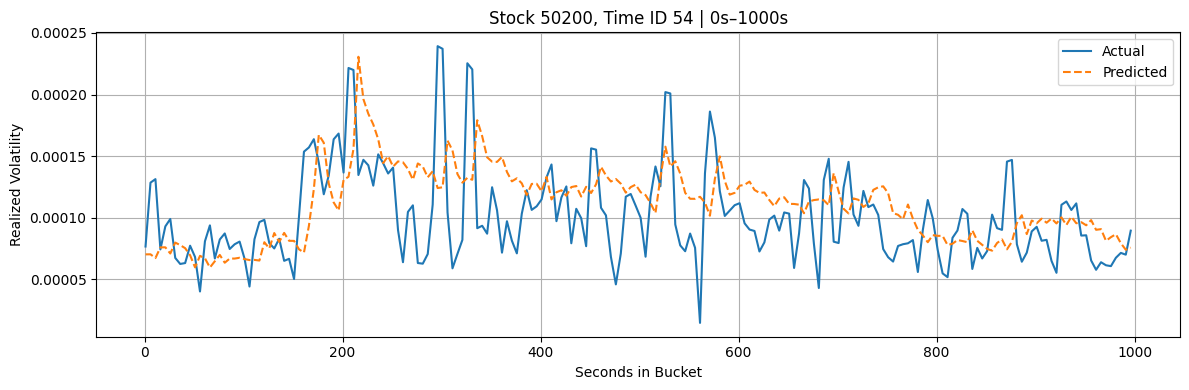

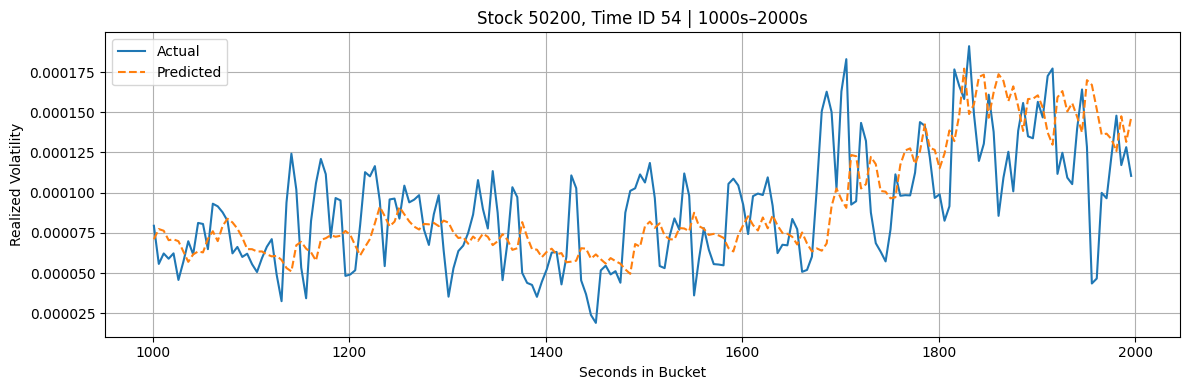

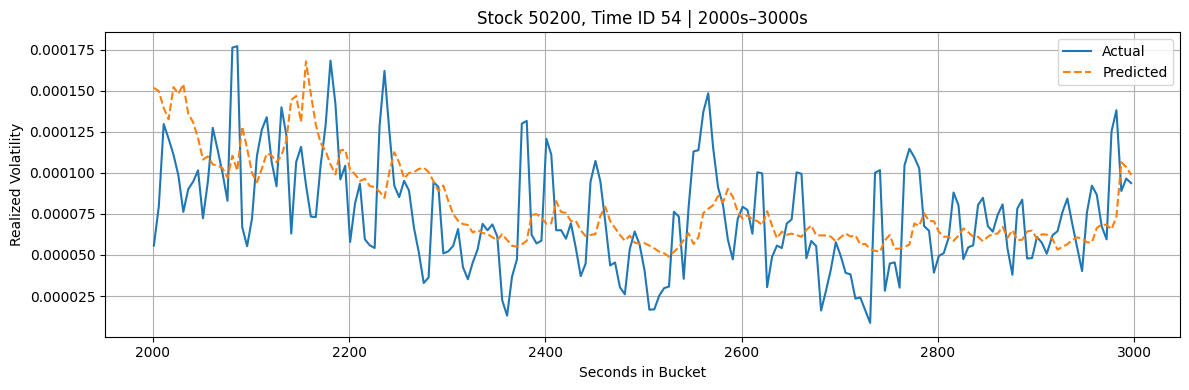

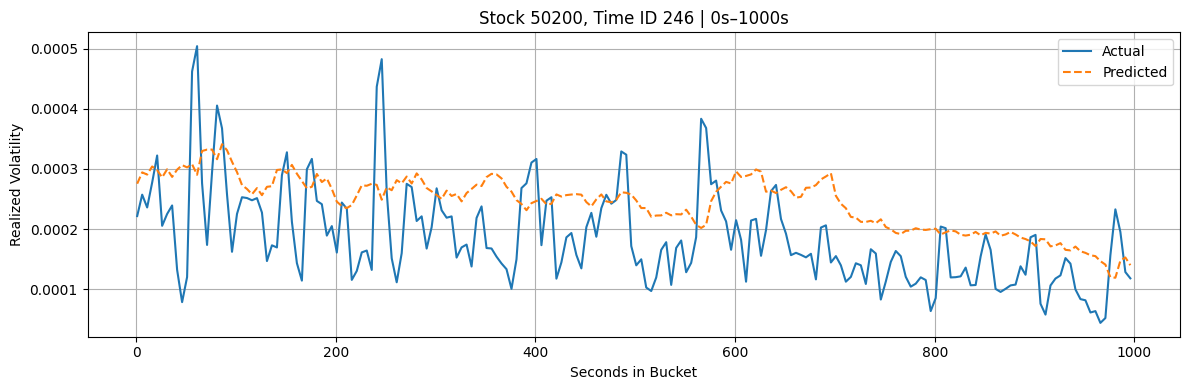

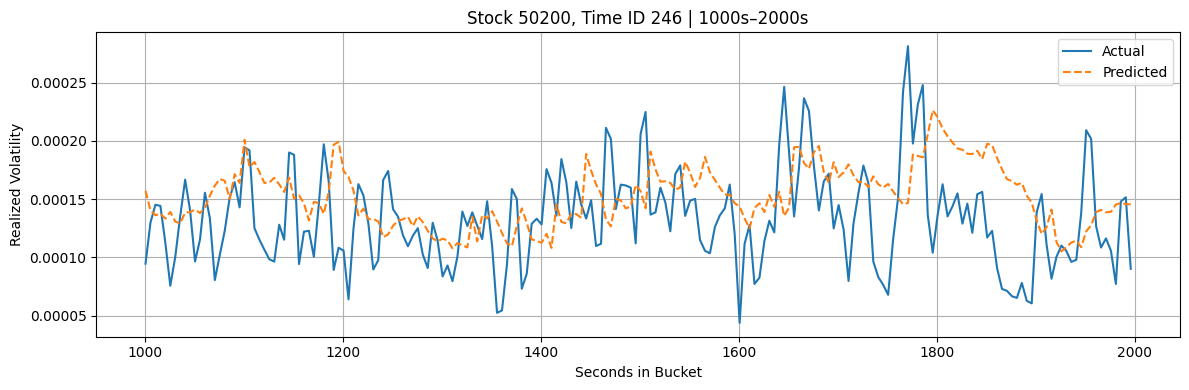

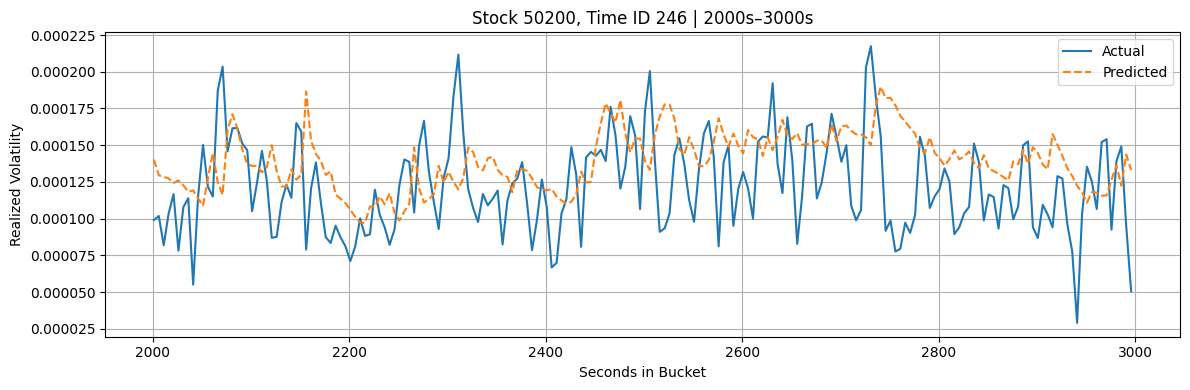

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# List of (stock_id, time_id) pairs to plot
time_ids = [14, 46, 54, 246]  # Add more as needed
stock_id = 50200  # Change if needed

# Plot segments
segments = [(0, 1000), (1000, 2000), (2000, 3000)]

for tid in time_ids:
    file_path = f"dashboard/predictions/pred_{stock_id}_{tid}.pkl"
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    df = pd.read_pickle(file_path)

    for start, end in segments:
        df_segment = df[(df["start_time"] >= start) & (df["start_time"] < end)]
        if df_segment.empty:
            continue

        plt.figure(figsize=(12, 4))
        plt.plot(df_segment["start_time"], df_segment["y_true"], label="Actual")
        plt.plot(df_segment["start_time"], df_segment["y_pred"], label="Predicted", linestyle="--")
        plt.title(f"Stock {stock_id}, Time ID {tid} | {start}s–{end}s")
        plt.xlabel("Seconds in Bucket")
        plt.ylabel("Realized Volatility")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [1]:
 pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.13-cp39-cp39-macosx_14_0_arm64.whl size=1090066 sha256=90c063548c83c26441672dad46380409eb0956afa9bfd46908e6c152796d758c
  Stored in directory: /Users/dais/Library/Caches/pip/wheels/b5/27/3a/3af994e83aba6610410c6091fd5adcf061627a99ee2c16f012
Successfully built dtaidistance
Note: you may need to restart the kernel to use updated packages.


                                         file  cutoff  window       mae  \
1161  dashboard/predictions/pred_50200_54.pkl    1070      30  0.000009   
1404  dashboard/predictions/pred_50200_54.pkl    1880      30  0.000015   
1149  dashboard/predictions/pred_50200_54.pkl    1030      30  0.000010   
264   dashboard/predictions/pred_50200_14.pkl     980      30  0.000007   
1167  dashboard/predictions/pred_50200_54.pkl    1090      30  0.000008   

          rmse       dtw  directional_acc  
1161  0.000011  0.000015              0.4  
1404  0.000017  0.000018              0.4  
1149  0.000012  0.000018              0.4  
264   0.000012  0.000019              0.4  
1167  0.000009  0.000019              0.6  


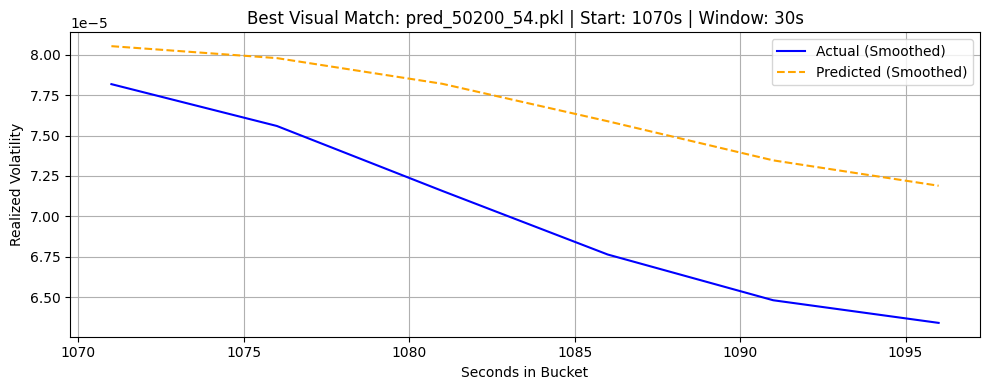

In [7]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw
from scipy.ndimage import gaussian_filter1d

cutoff_range = range(100, 3000, 10)  # Try different prediction start points
window_sizes = [30, 60, 90]  # forecast windows

results = []

for file in glob.glob("dashboard/predictions/pred_*.pkl"):
    df = pd.read_pickle(file)
    if 'y_pred' not in df.columns or df['y_pred'].isnull().all():
        continue

    for cutoff in cutoff_range:
        for w in window_sizes:
            df_window = df[(df['start_time'] >= cutoff) & (df['start_time'] <= cutoff + w)].copy()
            if df_window.empty or df_window['y_true'].isnull().all():
                continue

            y_true = df_window['y_true'].values
            y_pred = df_window['y_pred'].values

            mae = np.mean(np.abs(y_true - y_pred))
            rmse = np.sqrt(np.mean((y_true - y_pred)**2))
            dtw_dist = dtw.distance(y_true, y_pred)
            # Directional accuracy
            if len(y_true) > 1:
                actual_dir = np.sign(np.diff(y_true))
                pred_dir = np.sign(np.diff(y_pred))
                dir_acc = np.mean(actual_dir == pred_dir)
            else:
                dir_acc = np.nan  # Not enough points to compute


            results.append({
                "file": file,
                "cutoff": cutoff,
                "window": w,
                "mae": mae,
                "rmse": rmse,
                "dtw": dtw_dist,
                "directional_acc": dir_acc
            })

# Sort by best visual similarity (DTW)
df_results = pd.DataFrame(results).sort_values(by=["dtw", "mae", "rmse", "directional_acc"])
print(df_results.head(5))

# Visualize best result
top_row = df_results.iloc[0]
df_top = pd.read_pickle(top_row["file"])
df_window = df_top[(df_top['start_time'] >= top_row["cutoff"]) & 
                   (df_top['start_time'] <= top_row["cutoff"] + top_row["window"])].copy()

smoothed_actual = gaussian_filter1d(df_window['y_true'], sigma=2)
smoothed_pred = gaussian_filter1d(df_window['y_pred'], sigma=2)

plt.figure(figsize=(10, 4))
plt.plot(df_window['start_time'], smoothed_actual, label='Actual (Smoothed)', color='blue')
plt.plot(df_window['start_time'], smoothed_pred, label='Predicted (Smoothed)', linestyle='--', color='orange')
plt.title(f"Best Visual Match: {top_row['file'].split('/')[-1]} | Start: {top_row['cutoff']}s | Window: {int(top_row['window'])}s")
plt.xlabel("Seconds in Bucket")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


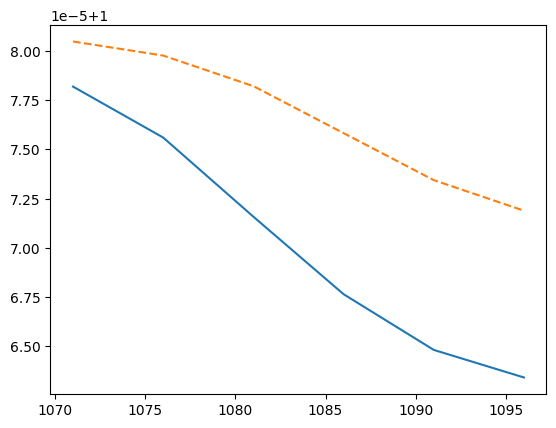

In [6]:
plt.plot(df_window['start_time'], gaussian_filter1d(np.exp(df_window['y_true']), sigma=2), label='Actual (exp + smoothed)')
plt.plot(df_window['start_time'], gaussian_filter1d(np.exp(df_window['y_pred']), sigma=2), label='Predicted (exp + smoothed)', linestyle='--')
